In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
%matplotlib inline


import numpy as np
import autoreject
import csv
import matplotlib.pyplot as plt
import pandas as pd
import mne
import os
import sys
from atpbar import atpbar
import glob
from mne.stats import permutation_cluster_test



In [2]:
# Suppress MNE output
#mne.set_log_level('WARNING')
mne.set_log_level('ERROR')
#mne.set_log_level('CRITICAL')
#mne.set_log_level('INFO')



## Visualisation to test for outliers

In [5]:
# # loop to check each individual response and see which ones I wish to exclude

# for sub in range(10):
#     for day in [1,2,3,4]:
#         for meditation in ['jhana', 'mindfulness']:
        
#             print(f'sub{sub} {day} {meditation}')
#             path = f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_ar/sub{sub}-day{day}-{meditation}_epo.fif'
#             try:
#                 epochs = mne.read_epochs(path)
#                 epochs.interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
#                 epochs.pick_channels(['Fz', 'Cz', 'FC1', 'FC2'])

#                 # # Plotting the evoked response
#                 # evokeds = epochs.average()
#                 # evokeds.plot()

#                 # Plotting the MMN
#                 evokeds_dev = epochs['-1'].average()
#                 evokeds_std = epochs['1'].average()

#                 evo_m_diff = mne.combine_evoked([evokeds_dev, evokeds_std], weights=[1, -1])
#                 evo_m_diff.plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")
#             except: 
#                 pass

## Import evoked responses into big dictionary

In [261]:
# Importing the data
evokeds = {}
for meditation in ['jhana', 'mindfulness']:
    evokeds[meditation] = {}
    evokeds[meditation]['std'] = []
    evokeds[meditation]['dev'] = []
    evokeds[meditation]['mmn'] = []


#for sub in [0,1,2,4,7,8,9]:
for sub in range(10):
    for meditation in ['jhana', 'mindfulness']:
        paths = glob.glob(f'/Users/jonasmago/PhD_code_data/github/eeg_jhana/notebooks/MMN/epochs_ar/sub{sub}-day1-{meditation}_epo.fif')
        epochs_list = [mne.read_epochs(path) for path in paths]
        epochs_list_picks = []
        
        for i in range(len(epochs_list)):
            epochs_list[i] = epochs_list[i].interpolate_bads(reset_bads=True).pick_types(eeg=True).filter(l_freq=None, h_freq=40)
                
        concatenated_epochs = mne.concatenate_epochs(epochs_list)
        evokeds[meditation]['std'].append(concatenated_epochs['1'].average())
        evokeds[meditation]['dev'].append(concatenated_epochs['-1'].average())
        evokeds[meditation]['mmn'].append(mne.combine_evoked([evokeds[meditation]['dev'][-1], evokeds[meditation]['std'][-1]], weights=[1, -1]))
        

## Creating MMN

In [259]:
# Creating the evoked responses

evo_j_std = mne.combine_evoked(evokeds['jhana']['std'], weights='equal')
evo_j_dev = mne.combine_evoked(evokeds['jhana']['dev'], weights='equal')
evo_m_std = mne.combine_evoked(evokeds['mindfulness']['std'], weights='equal')
evo_m_dev = mne.combine_evoked(evokeds['mindfulness']['dev'], weights='equal')

evo_all_std = mne.combine_evoked([evo_j_std, evo_m_std], weights='equal')
evo_all_dev = mne.combine_evoked([evo_j_dev, evo_m_dev], weights='equal')
evo_all_all = mne.combine_evoked([evo_all_std, evo_all_dev], weights='nave')


## Visualizing MMNs and topo

overall global response


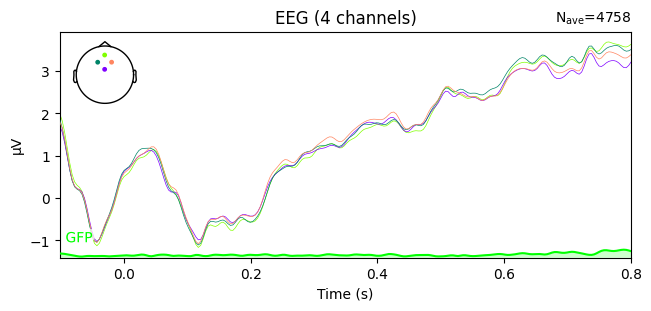

Global Evoked Response


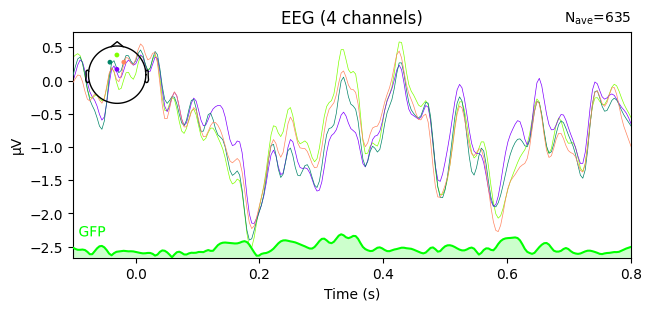

Jhana Evoked Response


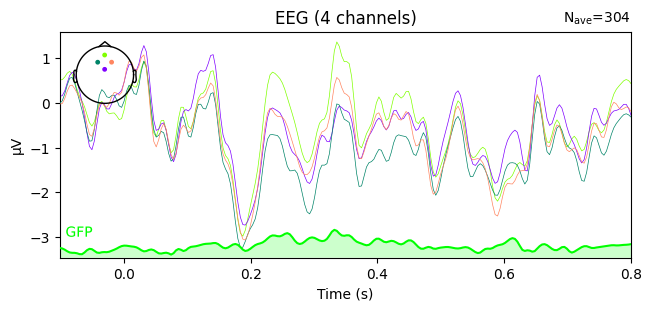

Mindfulnesss Evoked Response


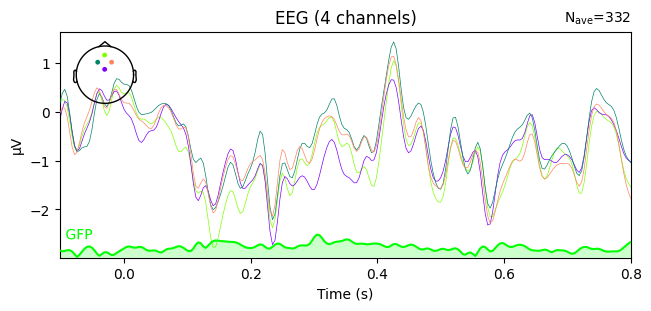

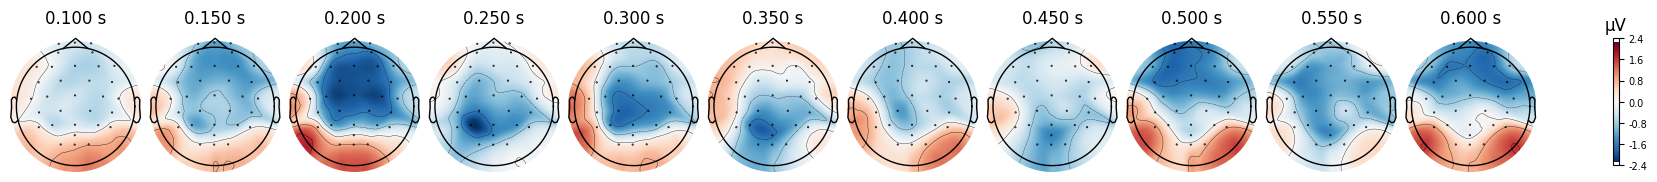

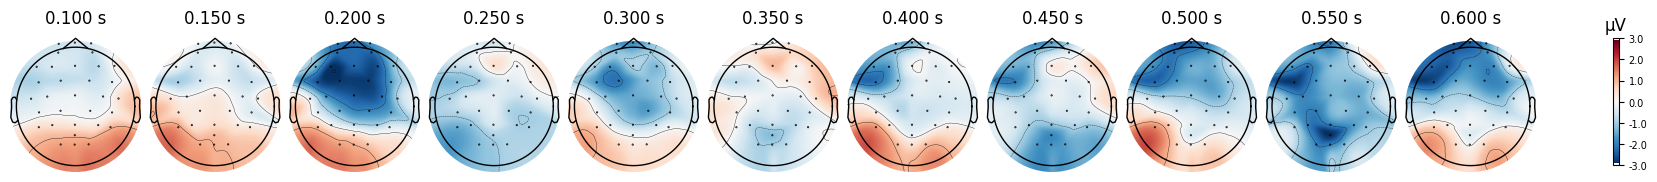

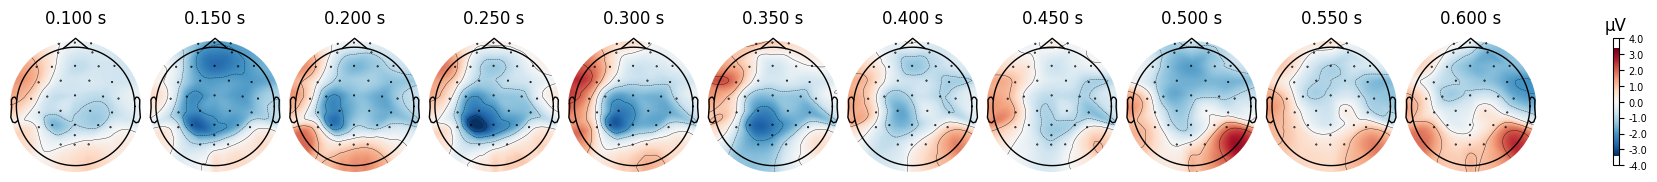

In [260]:
# Plotting the evoked responses for different conditions
print ('overall global response')
evo_all_all.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="overall global response", gfp=True, time_unit="s")

print('Global Evoked Response')
evo_diff = mne.combine_evoked([evo_all_dev, evo_all_std], weights=[1, -1])
evo_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Global Evoked Response", gfp=True, time_unit="s")

print('Jhana Evoked Response')
evo_j_diff = mne.combine_evoked([evo_j_dev, evo_j_std], weights=[1, -1])
evo_j_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Jhana Difference", gfp=True, time_unit="s")

print('Mindfulnesss Evoked Response')
evo_m_diff = mne.combine_evoked([evo_m_dev, evo_m_std], weights=[1, -1])
evo_m_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")



# for sub in range(10):
#     print (30*"#")
#     print (f'MMN, Jhana, sub: {sub}')
#     evo_j_diff_sub = mne.combine_evoked([evokeds['jhana']['dev'][sub], evokeds['jhana']['std'][sub]], weights=[1, -1])
#     evo_j_diff_sub.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")

#     print (f'MMN, Mindfulness, sub: {sub}')
#     evo_m_diff_sub = mne.combine_evoked([evokeds['mindfulness']['dev'][sub], evokeds['mindfulness']['std'][sub]], weights=[1, -1])
#     evo_m_diff_sub.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot(window_title="Mindfulness Difference", gfp=True, time_unit="s")


time_points = np.arange(0.1, 0.601, 0.05)  # Time in seconds

for evo in [evo_diff, evo_j_diff, evo_m_diff]:
    evo.plot_topomap(
        times=time_points
    )

print ('')

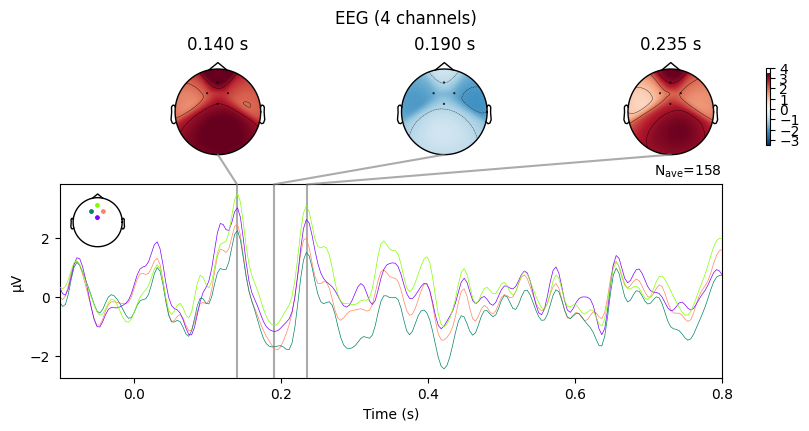

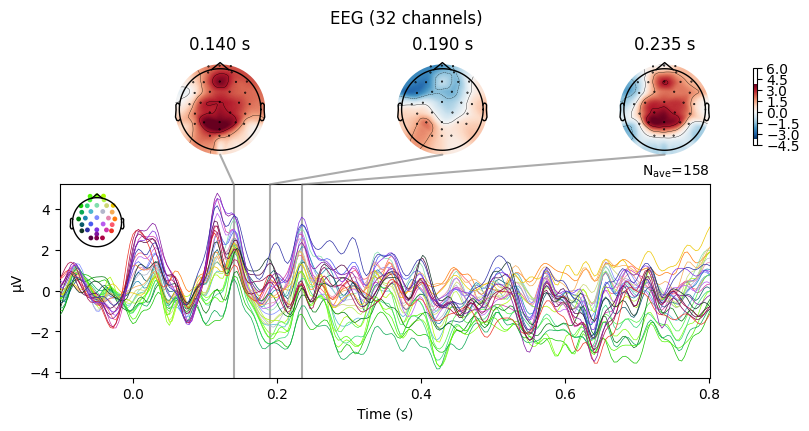

In [134]:
#### evo_jm_diff = mne.combine_evoked([evo_j_diff, evo_m_diff], weights=[1, -1])
evo_jm_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).plot_joint(times=[0.14, 0.19, 0.235])
evo_jm_diff.copy().plot_joint(times=[0.14, 0.19, 0.235])
print ('')



## Visualise the grant average across all channels and for both conditions in one plot

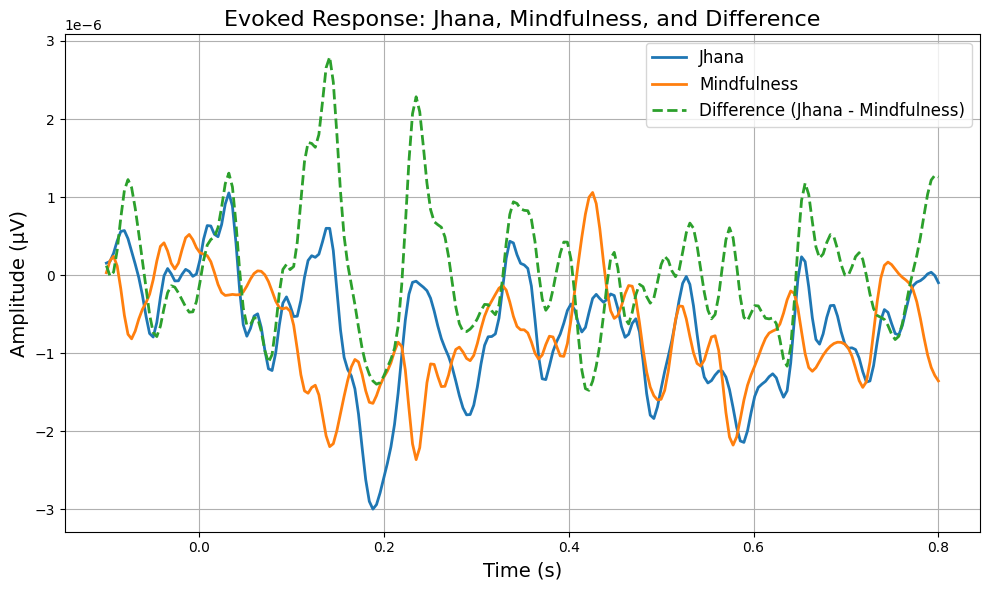

In [54]:
data_j = evo_j_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data()
data_m = evo_m_diff.copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data()

mean_j = data_j.mean(axis=0)
mean_m = data_m.mean(axis=0)
mean_dif = mean_j-mean_m


import numpy as np
import matplotlib.pyplot as plt

# Assume data has been processed and is in the variables:
# mean_j, mean_m, mean_dif

# Define the sampling rate and time range
sampling_rate = 256  # Hz
n_samples = mean_j.shape[0]
time = np.linspace(-0.1, 0.8, n_samples)  # From -0.1s to 0.8s

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Jhana
plt.plot(time, mean_j, label='Jhana', linewidth=2)

# Plot Mindfulness
plt.plot(time, mean_m, label='Mindfulness', linewidth=2)

# Plot Difference
plt.plot(time, mean_dif, label='Difference (Jhana - Mindfulness)', linewidth=2, linestyle='--')

# Add labels and legend
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (µV)', fontsize=14)  # µV is the common unit for EEG
plt.title('Evoked Response: Jhana, Mindfulness, and Difference', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()





## Repeated measure ANOVA

In [304]:
import numpy as np
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import mne

# Initialize storage for MMN data
mmn_data = {'Subject': [], 'Condition': [], 'Time': [], 'Amplitude': []}

# Process data for both conditions and all subjects
for meditation in ['jhana', 'mindfulness']:
    for sub in range(10):
        # Combine deviant and standard conditions
        mmn_ind = mne.combine_evoked(
            [evokeds[meditation]['dev'][sub], evokeds[meditation]['std'][sub]], weights='equal'
        )
        # Select relevant channels
        mmn_ind.pick_channels(['Fz', 'Cz', 'FC1', 'FC2'])
        # Get data and average over channels
        mmn_ind_data = mmn_ind.get_data().mean(axis=0)
        
        # Store the data for this subject and condition
        for t_idx, amplitude in enumerate(mmn_ind_data):
            mmn_data['Subject'].append(sub)
            mmn_data['Condition'].append(meditation)
            mmn_data['Time'].append(mmn_ind.times[t_idx])
            mmn_data['Amplitude'].append(amplitude)

# Convert to DataFrame
df_mmn = pd.DataFrame(mmn_data)

# Filter for specific time window (e.g., 100–200 ms)
time_window = (df_mmn['Time'] >= 0.15) & (df_mmn['Time'] <= 0.2)
df_window = df_mmn[time_window]

# Average amplitude within the time window for each subject and condition
df_avg = df_window.groupby(['Subject', 'Condition'])['Amplitude'].mean().reset_index()

# Reshape data for repeated-measures ANOVA
df_pivot = df_avg.pivot(index='Subject', columns='Condition', values='Amplitude').reset_index()

# Perform repeated-measures ANOVA
anova_df = pd.melt(df_pivot, id_vars='Subject', value_vars=['jhana', 'mindfulness'], var_name='Condition', value_name='MMN')
anova = AnovaRM(anova_df, 'MMN', 'Subject', within=['Condition']).fit()
print(anova.summary())


                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
Condition  0.6583 1.0000 9.0000 0.4381



## Compute the significance of each time point

In [338]:
j_data_sub = np.zeros([10,232])
m_data_sub = np.zeros([10,232])
for i in range(10):
    j_data_sub[i,:] = evokeds['jhana']['mmn'][i].copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)
    m_data_sub[i,:] = evokeds['mindfulness']['mmn'][i].copy().pick_channels(['Fz', 'Cz', 'FC1', 'FC2']).get_data().mean(axis=0)


p_values = []
for i,_ in enumerate(j_data_sub[0,:]):
    _, p = ttest_rel(j_data_sub[:,i], m_data_sub[:,i])
    p_values.append(float(p))

time_points = df_mmn['Time'].unique()
significant_times = time_points[np.array(p_values) < 0.05]
print(f"Significant time points: {significant_times}")

Significant time points: [0.140625   0.14453125 0.1484375 ]


## Plot again with shading the significant region

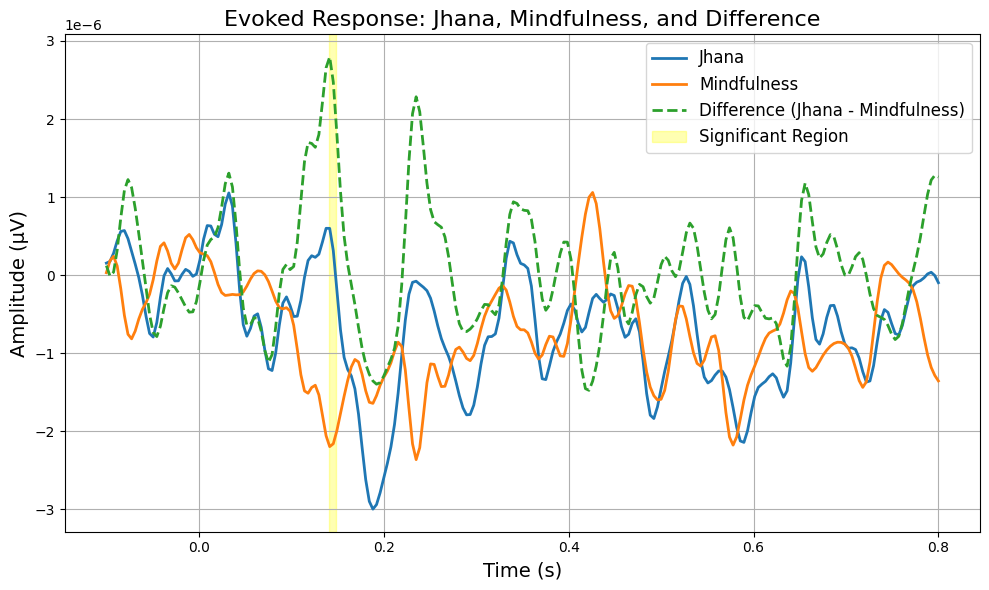

In [340]:
import numpy as np
import matplotlib.pyplot as plt

# Assume data has been processed and is in the variables:
# mean_j, mean_m, mean_dif

# Define the sampling rate and time range
sampling_rate = 256  # Hz
n_samples = mean_j.shape[0]
time = np.linspace(-0.1, 0.8, n_samples)  # From -0.1s to 0.8s

# Function to group significant time points into contiguous regions
def group_significant_times(times, threshold=1 / sampling_rate):
    regions = []
    current_region = [times[0]]
    for i in range(1, len(times)):
        if times[i] - times[i - 1] <= threshold:
            current_region.append(times[i])
        else:
            regions.append((current_region[0], current_region[-1]))
            current_region = [times[i]]
    regions.append((current_region[0], current_region[-1]))
    return regions

# Group significant time points into regions
significant_regions = group_significant_times(significant_times)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot Jhana
plt.plot(time, mean_j, label='Jhana', linewidth=2)

# Plot Mindfulness
plt.plot(time, mean_m, label='Mindfulness', linewidth=2)

# Plot Difference
plt.plot(time, mean_dif, label='Difference (Jhana - Mindfulness)', linewidth=2, linestyle='--')

# Highlight significant regions
for start, end in significant_regions:
    plt.axvspan(start, end, color='yellow', alpha=0.3, label='Significant Region' if start == significant_regions[0][0] else "")

# Add labels and legend
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (µV)', fontsize=14)  # µV is the common unit for EEG
plt.title('Evoked Response: Jhana, Mindfulness, and Difference', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [355]:
X = [j_data_sub, m_data_sub]


T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, threshold=2.6, n_permutations=1024, tail=0, 
                                   stat_fun=None, adjacency=None, n_jobs=None, seed=None, max_step=1, exclude=None, 
                                   step_down_p=0, t_power=1, out_type='indices', check_disjoint=False, buffer_size=1000, 
                                   verbose=True)


print(cluster_p_values)

stat_fun(H1): min=1.1817676551189073e-08 max=4.33196460903245
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

[0.95117188 0.98242188 0.91601562 0.79394531 0.95605469]


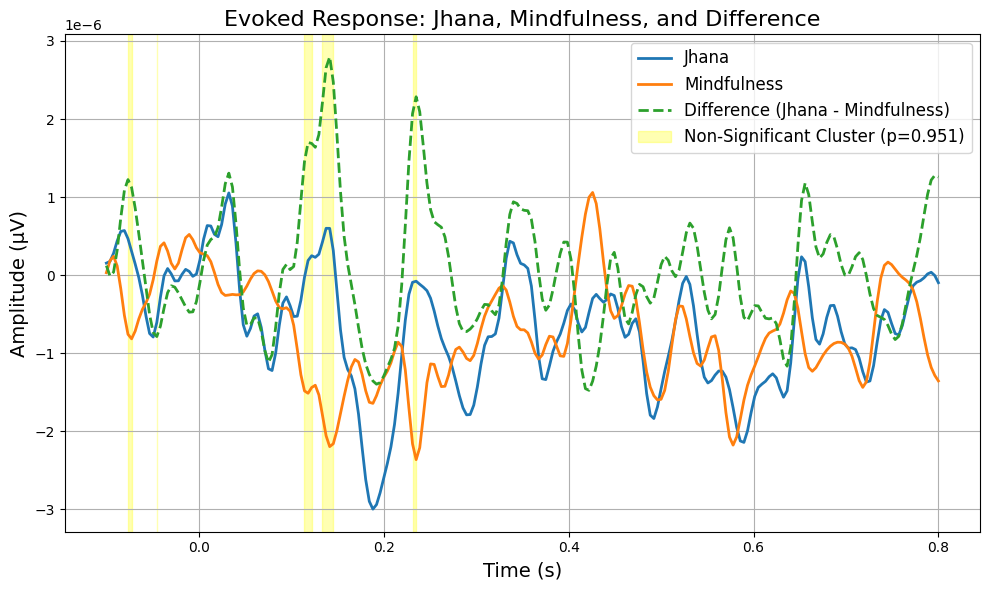

In [358]:
import matplotlib.pyplot as plt
import numpy as np

# Assume data has been processed and is in the variables:
# j_data_sub, m_data_sub, mean_j, mean_m, mean_dif, significant_times, clusters, cluster_p_values

# Define the sampling rate and time range
sampling_rate = 256  # Hz
n_samples = mean_j.shape[0]
time = np.linspace(-0.1, 0.8, n_samples)  # From -0.1s to 0.8s

# Function to group significant time points into contiguous regions
def group_significant_times(times, threshold=1 / sampling_rate):
    regions = []
    current_region = [times[0]]
    for i in range(1, len(times)):
        if times[i] - times[i - 1] <= threshold:
            current_region.append(times[i])
        else:
            regions.append((current_region[0], current_region[-1]))
            current_region = [times[i]]
    regions.append((current_region[0], current_region[-1]))
    return regions

# Group significant time points into regions
significant_regions = group_significant_times(significant_times)

# Compute average responses for visualization
jhana_mean = np.mean(j_data_sub, axis=0)
mindfulness_mean = np.mean(m_data_sub, axis=0)

# Start plotting
plt.figure(figsize=(10, 6))

# Plot the average responses
plt.plot(time, jhana_mean, label='Jhana', linewidth=2)
plt.plot(time, mindfulness_mean, label='Mindfulness', linewidth=2)
plt.plot(time, mean_dif, label='Difference (Jhana - Mindfulness)', linewidth=2, linestyle='--')

# Highlight clusters and display p-values
for cluster_idx, cluster in enumerate(clusters):
    cluster_p_val = cluster_p_values[cluster_idx]
    cluster_indices = cluster[0]  # Get the array of time indices for the cluster
    start, end = time[cluster_indices.min()], time[cluster_indices.max()]
    
    # Define color and transparency based on significance
    if cluster_p_val < 0.05:
        color = 'red'
        alpha = 0.5
        significance = 'Significant'
    else:
        color = 'yellow'
        alpha = 0.3
        significance = 'Non-Significant'
    
    # Highlight the cluster region
    plt.axvspan(start, end, color=color, alpha=alpha, 
                label=f'{significance} Cluster (p={cluster_p_val:.3f})' if cluster_idx == 0 else "")

# Add labels, legend, and grid
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (µV)', fontsize=14)
plt.title('Evoked Response: Jhana, Mindfulness, and Difference', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)

# Annotate the significant clusters
for cluster_idx, cluster in enumerate(clusters):
    cluster_p_val = cluster_p_values[cluster_idx]
    if cluster_p_val < 0.05:  # Annotate only significant clusters
        cluster_indices = cluster[0]
        start, end = time[cluster_indices.min()], time[cluster_indices.max()]
        mid_point = (start + end) / 2
        plt.text(mid_point, max(jhana_mean), f'p={cluster_p_val:.3f}', color='red', fontsize=10, ha='center')

# Show the plot
plt.tight_layout()
plt.show()
